# Machine learning framework for prediction of patient-hospital readmission in US
### Part 2: Binary Classification Models
#### Author: Andrea Marcela Huerfano Barbosa 
##### Modified: Apr 2022

### Contents
* [I. Loading the final dataset](#I.-Loading-the-final-dataset)
* [II. Model Performance](#II.-Model-Performance)
* [III. Unbalanced dataset](#III.-Unbalanced-dataset)
    * [1. Logistic Regression](#1.-Logistic-Regression)
    * [2. Weighted Logistic Regression](#2.-Weighted-Logistic-Regression)
    * [3. Artificial Neuronal Network](#3.-Artificial-Neuronal-Network)
    * [Model comparision](#Model-comparision)
* [IV. Oversampling](#IV.-Oversampling )
    * [1. Logistic Regression](#1.-Logistic-Regression-Model)
    * [2. KNeighbors](#2.-KNeighbors)
    * [3. Decision Tree Classifier](#3.-Decision-Tree-Classifier)
    * [4. Random Forest](#4.-Random-Forest)
    * [Model Comparision](#Model-Comparision)
* [V. Insights](#V.-Insights)
* [VI. Conclusions](#VI.-Conclusions)


### I. Loading the final dataset

Importing some libraries and fuctions.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE
from yellowbrick.model_selection import FeatureImportances
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras. metrics import FalseNegatives, FalsePositives, TrueNegatives
from tensorflow.keras. metrics import TruePositives, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import seaborn as sns
import time
sns.set()

In [2]:
time_start = time.time()

In [3]:
dataset=pd.read_csv('Clean_readmitted_apr2022.csv')
print('The input contains', dataset.shape[0], 'columns and ' , dataset.shape[1], 'rows')

The input contains 56195 columns and  57 rows


In [4]:
dataset.head(n=3).T

,0,1,2
Unnamed: 0,4267,5827,67608
encounter_id,24437208,29758806,189899286
patient_nbr,135,378,729
time_in_hospital,8,2,4
num_lab_procedures,77,49,68
num_procedures,6,1,2
num_medications,33,11,23
number_outpatient,0,0,0
number_emergency,0,0,0
number_inpatient,0,0,0


## II. Model Performance

Since the readmission correspond to a binary classification. I am going to use the following metrics to compare the performance across the models:

- Confussion Matrix
- Precision 
- Recall 
- F_1

In [5]:
def model_performance(model_prediction):
    cfm = confusion_matrix(y_test, model_prediction)

    true_negative = cfm[0][0]
    false_positive = cfm[0][1]
    false_negative = cfm[1][0]
    true_positive = cfm[1][1]

    Precision=round(precision_score(y_test, model_prediction),3)
    Recall=round(recall_score(y_test, model_prediction),3)
    F_1=round(f1_score(y_test, model_prediction),3)
    
    print('Confusion Matrix: \n', cfm, '\n')

    print('True Negative:', true_negative)
    print('False Positive:', false_positive)
    print('False Negative:', false_negative)
    print('True Positive:', true_positive,'\n')
    
    print ('Precision: {}'.format(Precision) )
    print ('Recall: {}'.format(Recall))
    print ('F_1: {}'.format(F_1))

### III. Unbalanced dataset
The readmitted classes follow a unbalance distribution since the majority of patients haven't been readmitted (92.7%).

In [6]:
func = lambda x: round(100*x.count()/dataset.shape[0],1)
readmitted_distribution=dataset.pivot_table(index='readmitted', values='encounter_id', aggfunc=func, margins=True)
readmitted_distribution.columns=['% Total']
readmitted_distribution

,% Total
readmitted,
0,92.7
1,7.3
All,100.0


Splitting into train and test sets

In [7]:
X=dataset.drop([ 'Unnamed: 0','encounter_id', 'patient_nbr', 'gender_Female','readmitted'] , axis=1)
y=dataset['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print('Training samples: {}'.format(X_train.shape[0]))
print('Testing samples: {}'.format(X_test.shape[0]))
print('Number of features: {}'.format(X_train.shape[1]))
print('Training outcome distribution: {}'.format(np.bincount(y_train)))
print('Testing outcome distribution: {}'.format(np.bincount(y_test)))

Training samples: 44956
Testing samples: 11239
Number of features: 52
Training outcome distribution: [41689  3267]
Testing outcome distribution: [10422   817]


#### 1. Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=500,random_state=0)
classifier.fit(X_train, y_train)
logistic_prediction = classifier.predict(X_test)

/Users/anmarphy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
model_performance(logistic_prediction)

Confusion Matrix: 
 [[10416     6]
 [  814     3]] 

True Negative: 10416
False Positive: 6
False Negative: 814
True Positive: 3 

Precision: 0.333
Recall: 0.004
F_1: 0.007


This model is not captured well those readmitted patients. 

#### 2. Weighted Logistic Regression

In [10]:
counts = np.bincount(y)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

In [11]:
classifier = LogisticRegression(max_iter=500,random_state=0,class_weight='balanced') 
classifier.fit(X_train, y_train)
weight_logistic_prediction = classifier.predict(X_test)

In [12]:
model_performance(weight_logistic_prediction)

Confusion Matrix: 
 [[6902 3520]
 [ 327  490]] 

True Negative: 6902
False Positive: 3520
False Negative: 327
True Positive: 490 

Precision: 0.122
Recall: 0.6
F_1: 0.203


The best fit was found under the option class\_weight='balanced' but there is not a good generalization for admitted even when the metrics are better than in the previous model.

#### 3. Artificial Neuronal Network

This is an artificial neural network with three densely-connected layers and use a relu activation function for the hidden layers and a sigmoid activation function for the output layer, as it is being used for a classification task. The loss function will be binary crossentropy.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 52)]              0         
_________________________________________________________________
activation (Activation)      (None, 52)                0         
_________________________________________________________________
First_hidden_layer (Dense)   (None, 256)               13568     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Second_hidden_layer (Dense)  (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Third_hidden_layer (Dense)   (None, 128)               32896 

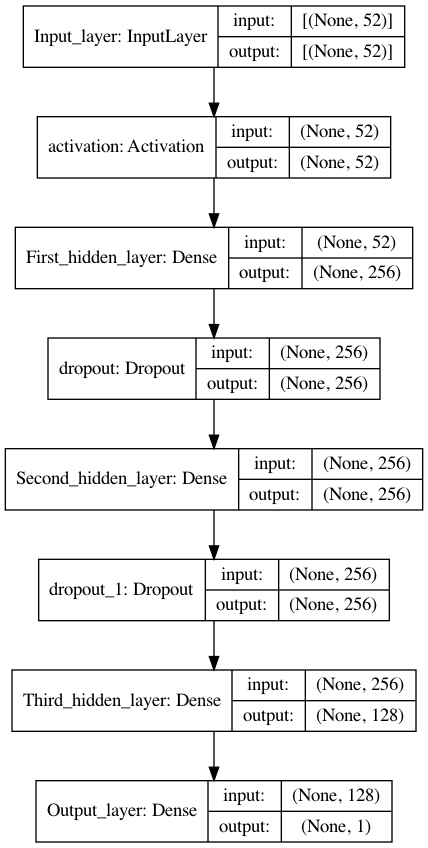

In [13]:
targets = y
targets = np.array(targets, dtype = 'uint8')

features = np.array(X,dtype = 'float32' )
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

scaler = StandardScaler()

scaler.fit(train_features)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features )


counts = np.bincount(train_targets)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

inputs = Input(shape=(train_features.shape[1],),name='Input_layer')


x = Activation('relu')(inputs)
x = Dense(256, activation='relu',name='First_hidden_layer')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu',name='Second_hidden_layer')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',name='Third_hidden_layer')(x)
outputs = Dense(1, activation='sigmoid', name='Output_layer')(x)


model = Model(inputs=inputs, outputs=outputs)
model.summary()
plot_model(model, to_file='readmission_model.png', 
           show_shapes=True)

In [14]:
metrics = [
    FalseNegatives(name="fn"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    TruePositives(name="tp"),
    Precision(name="precision"),
    Recall(name="recall")]

model.compile(optimizer=Adam(0.0001), loss="binary_crossentropy", metrics=metrics)

In [15]:
callbacks = [callbacks.ModelCheckpoint("readmission_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
) 

Epoch 1/100
22/22 - 4s - loss: 3.1129e-05 - fn: 1411.0000 - fp: 22607.0000 - tn: 19106.0000 - tp: 1832.0000 - precision: 0.0750 - recall: 0.5649 - val_loss: 0.7412 - val_fn: 191.0000 - val_fp: 7969.0000 - val_tn: 2429.0000 - val_tp: 650.0000 - val_precision: 0.0754 - val_recall: 0.7729
Epoch 2/100
22/22 - 1s - loss: 3.1115e-05 - fn: 1416.0000 - fp: 22969.0000 - tn: 18744.0000 - tp: 1827.0000 - precision: 0.0737 - recall: 0.5634 - val_loss: 0.7404 - val_fn: 179.0000 - val_fp: 7959.0000 - val_tn: 2439.0000 - val_tp: 662.0000 - val_precision: 0.0768 - val_recall: 0.7872
Epoch 3/100
22/22 - 1s - loss: 3.0979e-05 - fn: 1373.0000 - fp: 22575.0000 - tn: 19138.0000 - tp: 1870.0000 - precision: 0.0765 - recall: 0.5766 - val_loss: 0.7383 - val_fn: 173.0000 - val_fp: 7844.0000 - val_tn: 2554.0000 - val_tp: 668.0000 - val_precision: 0.0785 - val_recall: 0.7943
Epoch 4/100
22/22 - 1s - loss: 3.0899e-05 - fn: 1324.0000 - fp: 22489.0000 - tn: 19224.0000 - tp: 1919.0000 - precision: 0.0786 - recall: 0

Epoch 30/100
22/22 - 1s - loss: 2.9708e-05 - fn: 1385.0000 - fp: 16097.0000 - tn: 25616.0000 - tp: 1858.0000 - precision: 0.1035 - recall: 0.5729 - val_loss: 0.7081 - val_fn: 278.0000 - val_fp: 4892.0000 - val_tn: 5506.0000 - val_tp: 563.0000 - val_precision: 0.1032 - val_recall: 0.6694
Epoch 31/100
22/22 - 1s - loss: 2.9749e-05 - fn: 1425.0000 - fp: 16238.0000 - tn: 25475.0000 - tp: 1818.0000 - precision: 0.1007 - recall: 0.5606 - val_loss: 0.7059 - val_fn: 283.0000 - val_fp: 4806.0000 - val_tn: 5592.0000 - val_tp: 558.0000 - val_precision: 0.1040 - val_recall: 0.6635
Epoch 32/100
22/22 - 1s - loss: 2.9686e-05 - fn: 1385.0000 - fp: 15975.0000 - tn: 25738.0000 - tp: 1858.0000 - precision: 0.1042 - recall: 0.5729 - val_loss: 0.7053 - val_fn: 284.0000 - val_fp: 4775.0000 - val_tn: 5623.0000 - val_tp: 557.0000 - val_precision: 0.1045 - val_recall: 0.6623
Epoch 33/100
22/22 - 1s - loss: 2.9659e-05 - fn: 1376.0000 - fp: 15898.0000 - tn: 25815.0000 - tp: 1867.0000 - precision: 0.1051 - recal

Epoch 59/100
22/22 - 1s - loss: 2.9323e-05 - fn: 1364.0000 - fp: 15161.0000 - tn: 26552.0000 - tp: 1879.0000 - precision: 0.1103 - recall: 0.5794 - val_loss: 0.6901 - val_fn: 316.0000 - val_fp: 4345.0000 - val_tn: 6053.0000 - val_tp: 525.0000 - val_precision: 0.1078 - val_recall: 0.6243
Epoch 60/100
22/22 - 1s - loss: 2.9311e-05 - fn: 1387.0000 - fp: 14823.0000 - tn: 26890.0000 - tp: 1856.0000 - precision: 0.1113 - recall: 0.5723 - val_loss: 0.6969 - val_fn: 304.0000 - val_fp: 4481.0000 - val_tn: 5917.0000 - val_tp: 537.0000 - val_precision: 0.1070 - val_recall: 0.6385
Epoch 61/100
22/22 - 1s - loss: 2.9294e-05 - fn: 1373.0000 - fp: 15079.0000 - tn: 26634.0000 - tp: 1870.0000 - precision: 0.1103 - recall: 0.5766 - val_loss: 0.6956 - val_fn: 306.0000 - val_fp: 4451.0000 - val_tn: 5947.0000 - val_tp: 535.0000 - val_precision: 0.1073 - val_recall: 0.6361
Epoch 62/100
22/22 - 1s - loss: 2.9383e-05 - fn: 1339.0000 - fp: 15354.0000 - tn: 26359.0000 - tp: 1904.0000 - precision: 0.1103 - recal

Epoch 88/100
22/22 - 1s - loss: 2.9079e-05 - fn: 1324.0000 - fp: 14721.0000 - tn: 26992.0000 - tp: 1919.0000 - precision: 0.1153 - recall: 0.5917 - val_loss: 0.6887 - val_fn: 305.0000 - val_fp: 4446.0000 - val_tn: 5952.0000 - val_tp: 536.0000 - val_precision: 0.1076 - val_recall: 0.6373
Epoch 89/100
22/22 - 1s - loss: 2.9078e-05 - fn: 1296.0000 - fp: 15343.0000 - tn: 26370.0000 - tp: 1947.0000 - precision: 0.1126 - recall: 0.6004 - val_loss: 0.6948 - val_fn: 299.0000 - val_fp: 4553.0000 - val_tn: 5845.0000 - val_tp: 542.0000 - val_precision: 0.1064 - val_recall: 0.6445
Epoch 90/100
22/22 - 1s - loss: 2.9091e-05 - fn: 1321.0000 - fp: 14939.0000 - tn: 26774.0000 - tp: 1922.0000 - precision: 0.1140 - recall: 0.5927 - val_loss: 0.6871 - val_fn: 307.0000 - val_fp: 4424.0000 - val_tn: 5974.0000 - val_tp: 534.0000 - val_precision: 0.1077 - val_recall: 0.6350
Epoch 91/100
22/22 - 1s - loss: 2.9032e-05 - fn: 1316.0000 - fp: 14846.0000 - tn: 26867.0000 - tp: 1927.0000 - precision: 0.1149 - recal

In [16]:
y_pred_val = model.predict(val_features)
y_pred_val[y_pred_val > 0.5] = 1
y_pred_val[y_pred_val <=0.5] = 0
y_pred_val.reshape((y_pred_val.shape[0]))

y_pred_train = model.predict(train_features)
y_pred_train[y_pred_train > 0.5] = 1
y_pred_train[y_pred_train <=0.5] = 0
y_pred_train.reshape((y_pred_train.shape[0]))

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [17]:
# Squeezing
val_targets = np.squeeze(val_targets)
y_pred_val = np.squeeze(y_pred_val)
train_targets = np.squeeze(train_targets)
y_pred_train = np.squeeze(y_pred_train)

# False Negative Testing
fn_val = FalseNegatives()
fn_val.update_state(val_targets, y_pred_val)
fn_val = fn_val.result().numpy()

# False Negative Training
fn_train = FalseNegatives()
fn_train.update_state(train_targets, y_pred_train)
fn_train = fn_train.result().numpy()

#False Positive Testing
fp_val = FalsePositives()
fp_val.update_state(val_targets, y_pred_val)
fp_val = fp_val.result().numpy()
#
#False Positive Training
fp_train = FalsePositives()
fp_train.update_state(train_targets, y_pred_train)
fp_train = fp_train.result().numpy()

# Precision validación
pre_val = Precision()
pre_val.update_state(val_targets, y_pred_val)
pre_val = pre_val.result().numpy()

# Precision training
pre_train = Precision()
pre_train.update_state(train_targets, y_pred_train)
pre_train = pre_train.result().numpy()
#
# recall testing
re_val = Recall()
re_val.update_state(val_targets, y_pred_val)
re_val = re_val.result().numpy()
#
# recall testing
re_train = Recall()
re_train.update_state(train_targets, y_pred_train)
re_train = re_train.result().numpy()
# 

#metrics
metrics = {'False_positive_training':fp_train, 'False_positive_testing':fp_val,
           '%False_positives': np.round((fp_train+fp_val)/ len(X_train)*100,1),
           'Falses_negatives_training':fn_train, 'False_negatives_testing':fn_val,
           '%False_negatives': np.round((fn_train+fn_val)/ len(X_train)*100,1),
           'Precision_train': np.round(pre_train,2), 'Precision_testing': np.round(pre_val,2),
           'Recall_train': np.round(re_train,2), 'Recall_testing':np.round(re_val,2),
            'F_1':np.round(2*(pre_val*re_val)/(pre_val+re_val), 2)}
metrics

{'False_positive_training': 16693.0,
 'False_positive_testing': 4483.0,
 '%False_positives': 47.1,
 'Falses_negatives_training': 1081.0,
 'False_negatives_testing': 300.0,
 '%False_negatives': 3.1,
 'Precision_train': 0.11,
 'Precision_testing': 0.11,
 'Recall_train': 0.67,
 'Recall_testing': 0.64,
 'F_1': 0.18}

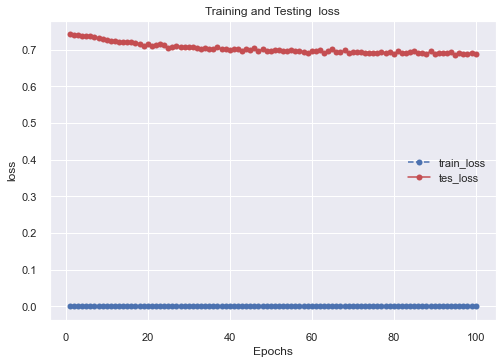

In [18]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    tes_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, tes_metrics, 'ro-')
    plt.title('Training and Testing  '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'tes_'+metric])
    plt.show()
plot_metric(history, 'loss')

Even when the loss in both: training and testing, show a decreasing trend, the metrics reflect that the model doesn't have a good fit specially detecting the admitted patients.

#### Model comparision



| Model |  Precision | Recall| F1 |
| --- | --- | --- | --- |
|Logistic Regression           |0.333  |0.004 |0.007|
|Weighted Logistic Regression  |0.121  |0.595 |0.202 |
|Artificial Neuronal Network   |0.110  |0.570 | 0.180 |

Comparing the models, any of them have a good generalization for the admitted classification.

## IV. Oversampling 

Unbalanced data substantially compromises the learning process, since most of the standard machine learning algorithms expect balanced class distribution or an equal misclassification cost. I worked with the package [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) which offers a number of re-sampling techniques, in order to apply the SMOTE methodology where the data balancing can be performed by oversampling such that new samples are generated the smallest class to reach the balancing ratio.

In [19]:
sm=SMOTE(random_state=42)
X_res, y_res=sm.fit_sample(X,y)
print('Original train dataset shape %s' % Counter(y))
print('Resampled train dataset shape %s' % Counter(y_res))

Original train dataset shape Counter({0: 52111, 1: 4084})
Resampled train dataset shape Counter({1: 52111, 0: 52111})


In [20]:
X=dataset.drop([ 'Unnamed: 0','encounter_id', 'patient_nbr','readmitted', 'gender_Female'] , axis=1)
y=dataset['readmitted']

In [21]:
sm=SMOTE(random_state=42)
X_res, y_res=sm.fit_sample(X,y)
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 52111, 1: 4084})
Resampled dataset shape Counter({1: 52111, 0: 52111})


Splitting the dataset in training and testing sets.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_res, 
                                                    y_res,
                                                    test_size=0.2,
                                                    stratify=y_res,
                                                    random_state=42)
print('Training samples: {}'.format(X_train.shape[0]))
print('Testing samples: {}'.format(X_test.shape[0]))
print('Number of features: {}'.format(X_train.shape[1]))
print('Training outcome distribution: {}'.format(np.bincount(y_train)))
print('Testing outcome distribution: {}'.format(np.bincount(y_test)))

Training samples: 83377
Testing samples: 20845
Number of features: 52
Training outcome distribution: [41688 41689]
Testing outcome distribution: [10423 10422]


In order to identify the best parameters for the models, I am going to use a grid search, it's imporant to realize that this part will be time consuming since the algorithm compare different models using list of parameters.

In [23]:
def best_model (model, parameter_grid):
    def grid_search(X_train, y_train, clf, param_grid, k):
        modelos=GridSearchCV(clf, 
                       param_grid=param_grid, 
                       cv=k,
                       return_train_score=True)
        modelos=modelos.fit(X_train,y_train)
        return modelos

    param_grid = parameter_grid

    clf = model
    gsearch = grid_search(X_train, y_train, clf, param_grid, k=3)

    print(f'Best hyperparameters:\n {gsearch.best_params_}')
    print(f'Best score (validation): {gsearch.best_score_}')

#### 1. Logistic Regression Model

In [24]:
logistic_model = LogisticRegression(max_iter=10000, random_state=0, class_weight='balanced')
logistic_parameter_grid = {'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']}
best_model (logistic_model, logistic_parameter_grid)

Best hyperparameters:
 {'solver': 'newton-cg'}
Best score (validation): 0.9514734125181267


In [25]:
3

3

In [26]:
X_train.shape

(83377, 52)

In [27]:
classifier = LogisticRegression(max_iter=10000,random_state=0, class_weight='balanced', solver='newton-cg') ##lbfgs is the  solver defaulf
classifier.fit(X_train, y_train)
over_logistic_prediction = classifier.predict(X_test)
model_performance(over_logistic_prediction)

Confusion Matrix: 
 [[10417     6]
 [ 1003  9419]] 

True Negative: 10417
False Positive: 6
False Negative: 1003
True Positive: 9419 

Precision: 0.999
Recall: 0.904
F_1: 0.949


This model reflects a good generalization for both clases and the biggest advantages is that it is interpretable which allow us to identify the risk and protective factors.

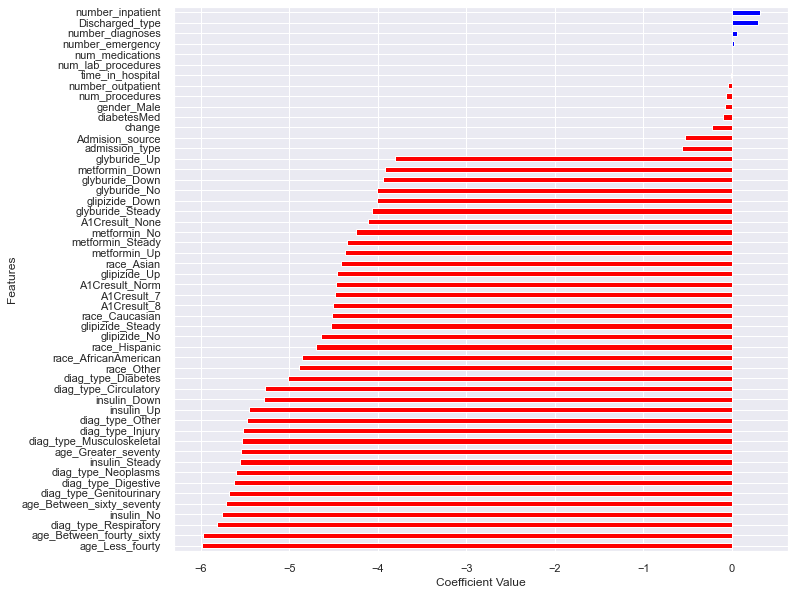

In [28]:
coeff = list(classifier.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['coef'] = coeff
features.sort_values(by=['coef'], ascending=True, inplace=True)
features['positive'] = features['coef'] > 0
features.set_index('Features', inplace=True)
features.coef.plot(kind='barh', figsize=(11, 10),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Coefficient Value')
plt.show()

In [29]:
features['exp_coef'] = np.exp(features['coef'])

p_values= list(f_regression(X_train, y_train,center=True)[1])
f= list(f_regression(X_train, y_train,center=True)[0])
features['p-values'] = p_values
features['f1']=f
features=features.drop(['positive'], axis=1)
features

,coef,exp_coef,p-values,f1
Features,,,,
age_Less_fourty,-5.988992,0.002506,2.575872e-21,89.893823
age_Between_fourty_sixty,-5.979930,0.002529,3.615300e-62,277.329799
diag_type_Respiratory,-5.817190,0.002976,1.540686e-221,1015.649817
insulin_No,-5.761098,0.003148,9.974274e-53,233.889354
age_Between_sixty_seventy,-5.720345,0.003279,8.076548e-52,229.712510
diag_type_Genitourinary,-5.680664,0.003411,3.030946e-22,94.133214
diag_type_Digestive,-5.628625,0.003594,3.862252e-145,660.711327
diag_type_Neoplasms,-5.600650,0.003695,6.805381e-70,312.912105
insulin_Steady,-5.551707,0.003881,0.000000e+00,1811.143640


### 2. KNeighbors

No parameter tecnique, the classification rule checks the closest k-neighbors and based on the distribution within classes classify the new observation. 

In [30]:
kn_model = KNeighborsClassifier()
kn_parameter_grid = {'n_neighbors':[2,5, 10, 50]}
best_model (kn_model, kn_parameter_grid)

Best hyperparameters:
 {'n_neighbors': 2}
Best score (validation): 0.8944672701915483


In [31]:
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)
k_prediction = classifier.predict(X_test)
model_performance(k_prediction)

Confusion Matrix: 
 [[ 8693  1730]
 [   93 10329]] 

True Negative: 8693
False Positive: 1730
False Negative: 93
True Positive: 10329 

Precision: 0.857
Recall: 0.991
F_1: 0.919


This model is better classifying admitted than no-admitted according to the precission and recall comparision.

### 3. Decision Tree Classifier

Non-parametric supervised learning machine learning algorithm invariant under scaling, create biased trees if some classes dominate for that reason was not implemented with the unbalance dataset.

In [32]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_parameter_grid = {"max_depth": range(5, 60), "criterion": ["gini", "entropy"],}
best_model (tree_model, tree_parameter_grid)

Best hyperparameters:
 {'criterion': 'entropy', 'max_depth': 19}
Best score (validation): 0.9198699505589762


In [33]:
tree_model = DecisionTreeClassifier(max_depth=19, criterion='entropy',random_state=42) # vamos a usar un árbol de profundidad 2
tree_model.fit(X_train, y_train)
pred_tree=tree_model.predict(X_test) 
model_performance(pred_tree)

Confusion Matrix: 
 [[9665  758]
 [ 833 9589]] 

True Negative: 9665
False Positive: 758
False Negative: 833
True Positive: 9589 

Precision: 0.927
Recall: 0.92
F_1: 0.923


/Users/anmarphy/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


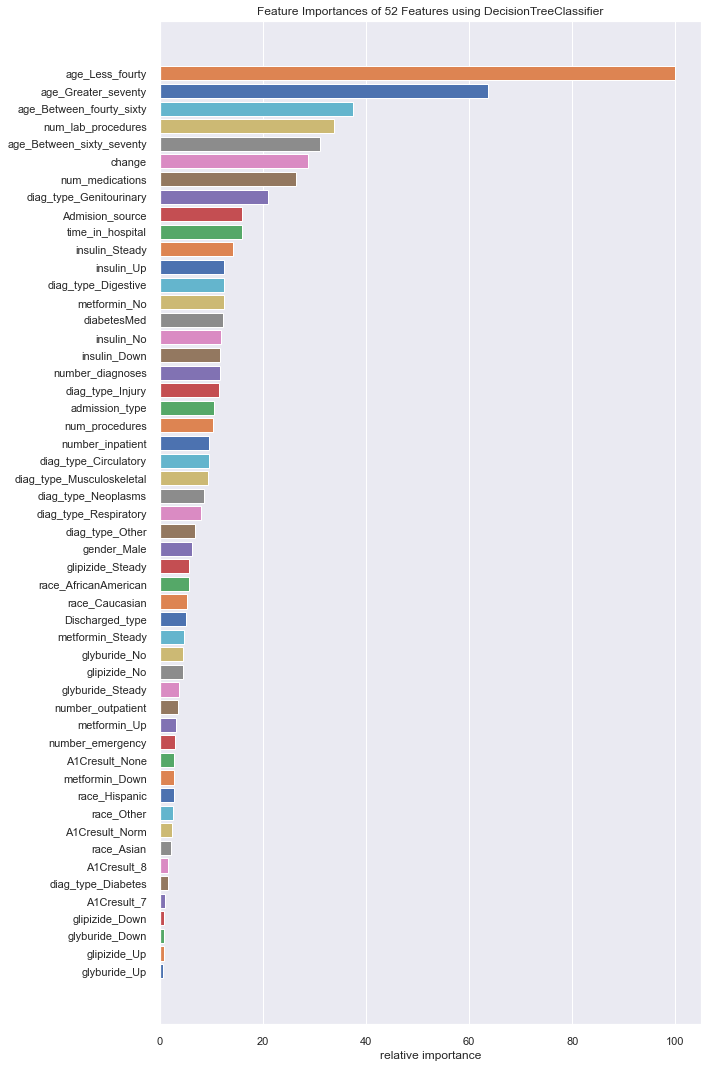

In [34]:
plt.figure(figsize=(10,15))
viz = FeatureImportances(tree_model)
viz.fit(X_res, y_res)
viz.show()
plt.show()

This model classify with a similar goodness both of the admitted classes.

### 4. Random Forest

Combine average of several individual trees and . The predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated.

In [35]:
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_param_grid = {"criterion": ["gini", "entropy"],
             "max_depth": range(5, 40)} #estaba en 60
best_model (random_forest_model, random_forest_param_grid)

Best hyperparameters:
 {'criterion': 'entropy', 'max_depth': 32}
Best score (validation): 0.9589335139335008


In [36]:
clf=RandomForestClassifier(criterion='entropy', max_depth=32,random_state=0)
clf.fit(X_train,y_train)
random_f_prediction=clf.predict(X_test)
model_performance(random_f_prediction)

Confusion Matrix: 
 [[10402    21]
 [  816  9606]] 

True Negative: 10402
False Positive: 21
False Negative: 816
True Positive: 9606 

Precision: 0.998
Recall: 0.922
F_1: 0.958


In [37]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

num_lab_procedures           0.062553
num_medications              0.054287
age_Greater_seventy          0.046009
age_Between_fourty_sixty     0.045650
insulin_Steady               0.045343
insulin_No                   0.039313
time_in_hospital             0.039046
age_Between_sixty_seventy    0.035943
metformin_No                 0.030080
number_diagnoses             0.028832
num_procedures               0.028002
age_Less_fourty              0.027872
change                       0.027047
race_Caucasian               0.025139
diag_type_Respiratory        0.025019
race_AfricanAmerican         0.024924
Admision_source              0.024394
diag_type_Other              0.023703
admission_type               0.022558
diag_type_Circulatory        0.022483
insulin_Up                   0.020686
diabetesMed                  0.020606
gender_Male                  0.020383
diag_type_Digestive          0.019911
insulin_Down                 0.019089
number_inpatient             0.018915
metformin_St

This is the best model for classification purposes, however the Random forest is a black box since we dont have a path to describe the variables inside the model in case that we want to identify the risk and protective variables.

#### Model Comparision

| Model |  Precision | Recall| F1 |
| --- | --- | --- | --- |
|Logistic Regression            | 0.999| 0.904 | 0.949 |
|KNeighbors   |  0.857 | 0.991 | 0.919 |
|Decision Tree Classifier    | 0.927 | 0.920 | 0.923 |
|Random Forest  |  0.998 | 0.922 | 0.958 |


Depending on the purpose of the research we have two models with a really good generalization:
* If the main task is classify the patients minimizing the error of readmission, my suggestion is to use the Random forest model since it has the best performance.
* For identifying risk and protective factor my recommendation is to use the Logistic regression since it is the second best model and it is interpretable.

In [38]:
time_end = time.time()
print(f"\nTotal running time: {round((time_end - time_start)/60,1)} minutes")


Total running time: 93.3 minutes


## V. Insights

The insights below are associated with the logistic model obtained with the oversampling approach.

#### Protective factors
- Admission type: People who were not in Emergency decrease their odds in 43% of being readmitted compared with those in Emergency. 
- Change: Changing the diabetics medications decrease in 20% the  odds of being readmitted.
- DiabetesMed: For patients with any diabetic medication prescribed the odds of being readmitted decrease in 9%.
- Gender: Being male decrease in 7% the odds of being readmitted.
- Number of procedures: For each adittional procedures different than lab tests performed during the encounter the odds of being readmitted decrease in 6%.
- Number outpatient: for each adittional outpatient visit the odds of being readmitted decrease in 4%.
- Time in hospital: For each adittional day in the hospital the odds of being readmitted decrease in 1%


#### Risk factors
- Number inpatient: for each aditional number of inpatient visits the odds of being readmitted increase in 37%
- Discharged type: when the discharge is not at home the odds of being readmitted increase in 34%
- Number diagnoses: for each aditional number of diagnoses reported into the system the odds of being readmitted increase in 5%
- Number emergency: for each aditional number of emergency visits of the patient in the year preceding the odds of being readmitted increase in 3%
- Age factors: Increasing the age increase the chance of being readmitted.
- Primary diagnostic: when the primary diagnostic is diabetes the patiend has a higher odds of being readmitted, follow by Circulatory diagnostic. The other ones dont reflect a sigificative effect in being readmitted.

## VI. Conclusions

* Using oversampling to balance the classes guarantee a better performance since most of the machine learning algorithms needs a similar proportion into the classes.
* After checking with various machine learning models, for classify the patients minimizing the error of readmission, my suggestion is to use the *Random forest* model since it has the best performance.
* For identifying risk and protective risk my suggestion is the *Logistic Regression* model since it is the second best model and it is interpretable.
    * The top three of protective factors are: not being in Emergency as admission type, have any change in the diabetics medications and  have any diabetic medication.
    * When the patient has been more in contact with the hospital: more days in the hospital, more procedures or more outpatient visits, the odds of being readmitted decrease.
    * The top three of risk factors are: number of inpatient visits, the discharge is not at home,  number of diagnoses reported into the system.

# VII. Experimentación:
  *  Random search en vez de grid search
  * Usar un framework de optimización de parámetros como Optuna
  * Ampliar la cantidad de parámetros a tunear
  *  Ensayar con otros modelos: XGboost..
  *  Ensambles de modelos: Majority...
  * Smote sólo para el subconjunto de training
  * Mejorar la arquitectura de la red: Neuronas, capas...
  * Presentar las métricas en training y testing para contrastar y evitar overfitting
  * Incluir learning and validation curves
  * AWS: Random Cut Forest
  